In [1]:
import sys
import os

_module_path = os.path.abspath("../")
print(_module_path)
sys.path.append(_module_path)

c:\Users\86994\Desktop\camera_kit


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from calibration_libs.ccalibration import CCameraCalibration
from calibration_libs.creconstruction import Reconstruction
from  calibration_libs.creconstruction import  Calc3DPose
from calibration_libs.cccparameters import CParameters


In [3]:
from calibration_libs.utils import get_chess_corners, get_chess_corners_world, img_to_world_by_dis, world_to_img_l

In [4]:
images_path =  os.path.abspath('./images_640x480')

In [5]:
# 标定板参数
chessSize=[11, 8] # col, row, 长边设置为col, 短边row , col作为x轴， row作为y轴
chessCellLen=20

In [6]:
#相机标定类
mycc = CCameraCalibration()  #初始化
mycc.set_calibration_images(images_path, 15, 480, 1280, size=chessSize, length=chessCellLen) #设置标定图像的路径和图片数量

['WIN_20251207_14_54_12_Pro.jpg', 'WIN_20251207_14_54_42_Pro.jpg', 'WIN_20251207_14_54_48_Pro.jpg', 'WIN_20251207_14_54_55_Pro.jpg', 'WIN_20251207_14_55_08_Pro.jpg', 'WIN_20251207_14_55_13_Pro.jpg', 'WIN_20251207_14_55_20_Pro.jpg', 'WIN_20251207_14_55_26_Pro.jpg', 'WIN_20251207_14_55_45_Pro.jpg', 'WIN_20251207_14_55_53_Pro.jpg', 'WIN_20251207_14_56_02_Pro.jpg', 'WIN_20251207_14_56_07_Pro.jpg', 'WIN_20251207_14_56_32_Pro.jpg', 'WIN_20251207_14_56_40_Pro.jpg', 'WIN_20251207_14_56_44_Pro.jpg', 'WIN_20251207_14_56_48_Pro.jpg', 'WIN_20251207_14_57_01_Pro.jpg', 'WIN_20251207_14_57_06_Pro.jpg', 'WIN_20251207_14_57_11_Pro.jpg', 'WIN_20251207_14_57_16_Pro.jpg']


In [7]:
mycc.stereo_calibration(True, reversal=False) #进行双目立体标定，得到内参矩阵、畸变系数、重映射矩阵map、重投影矩阵Q等
mycc.print_p()

you have calibrated !
左图对应相机的内参..................................
[[338.65445417   0.         294.63245868]
 [  0.         338.79315821 235.99560417]
 [  0.           0.           1.        ]]

右图对应相机的内参..................................
[[338.19616913   0.         279.11848074]
 [  0.         338.04469341 231.75555723]
 [  0.           0.           1.        ]]

重投影矩阵Q..................................
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -2.93751724e+02]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -2.42089602e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.38418926e+02]
 [ 0.00000000e+00  0.00000000e+00  1.65904301e-02 -0.00000000e+00]]


图像形状: (480, 1280, 3)


Text(0.5, 1.0, 'Remap')

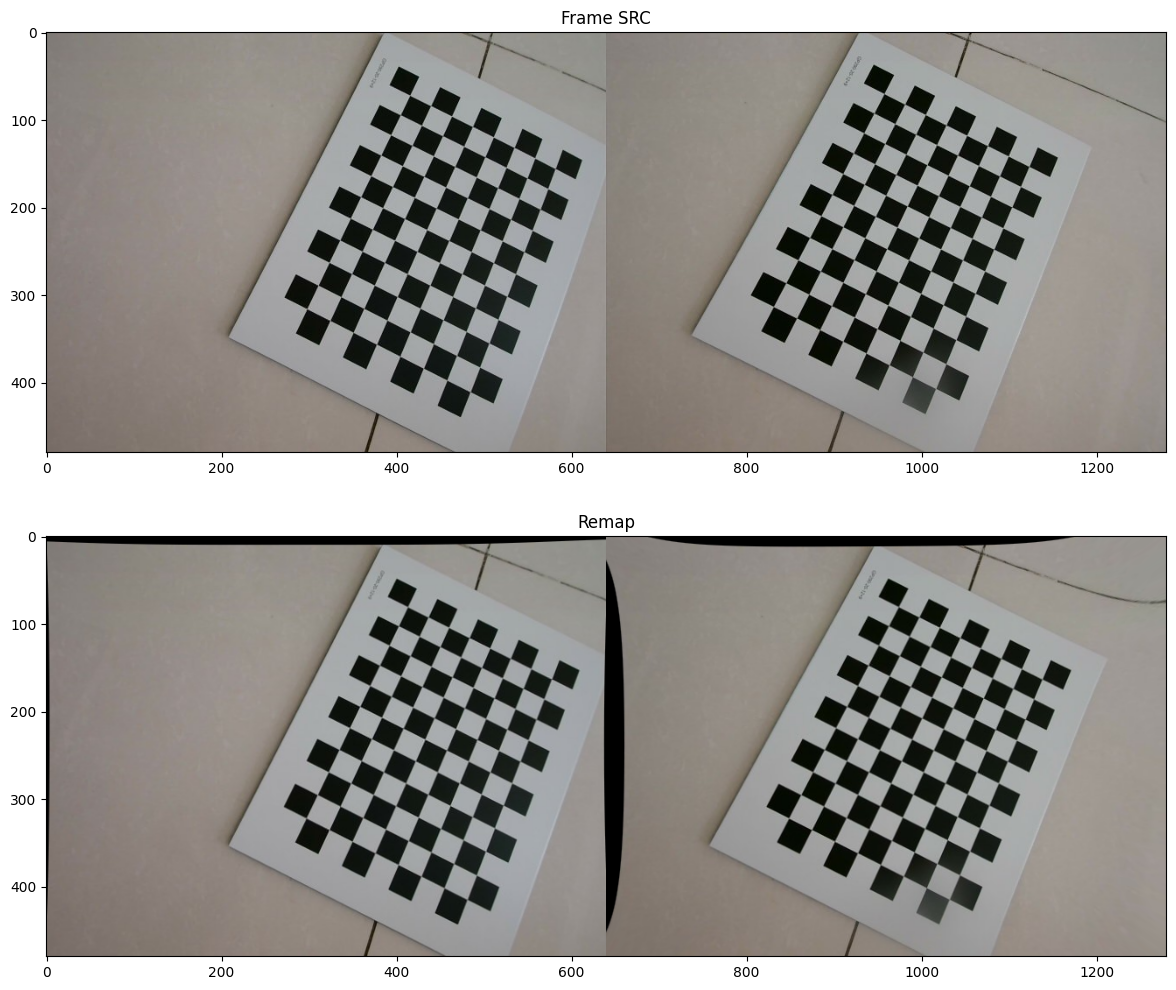

In [8]:
# 立体校正
img_src = cv2.imread('./images_640x480/WIN_20251207_14_55_08_Pro.jpg')
print("图像形状:", img_src.shape)
_height, _width, _c = img_src.shape
left_src = img_src[:, 0: _width//2] #拆分左右图像
right_src = img_src[:, _width//2:]

#立体校正
left_remap = cv2.remap(left_src, mycc._leftParameters["map1"], mycc._leftParameters["map2"], cv2.INTER_LINEAR)
right_remap = cv2.remap(right_src, mycc._rightParameters["map1"], mycc._rightParameters["map2"], cv2.INTER_LINEAR)
img_remap =  cv2.hconcat([left_remap, right_remap]) #合并校正后图像

plt.figure(figsize=(16,12))
plt.subplot(2, 1, 1)
plt.imshow(cv2.cvtColor(img_src, cv2.COLOR_BGR2RGB))
plt.title("Frame SRC")   # 左图标题

plt.subplot(2, 1, 2)
plt.imshow(cv2.cvtColor(img_remap, cv2.COLOR_BGR2RGB))
plt.title("Remap")   # 左图标题

In [9]:
# 对齐校验

In [10]:
_ret, left_src_corners, _left_src_corners_draw = get_chess_corners(left_src, chessSize, draw_flag=True)
_ret, right_src_corners, _right_src_corners_draw = get_chess_corners(right_src, chessSize, draw_flag=True)
_src_draw_concat = cv2.hconcat([_left_src_corners_draw, _right_src_corners_draw]) #合并绘图

# remap 图
_ret, left_remap_corners, _left_remap_corners_draw = get_chess_corners(left_remap, chessSize, draw_flag=True)
_ret, right_remap_corners, _right_remap_corners_draw = get_chess_corners(right_remap, chessSize, draw_flag=True)
_remap_draw_concat = cv2.hconcat([_left_remap_corners_draw, _right_remap_corners_draw]) #合并绘图

Text(0.5, 1.0, 'Remap')

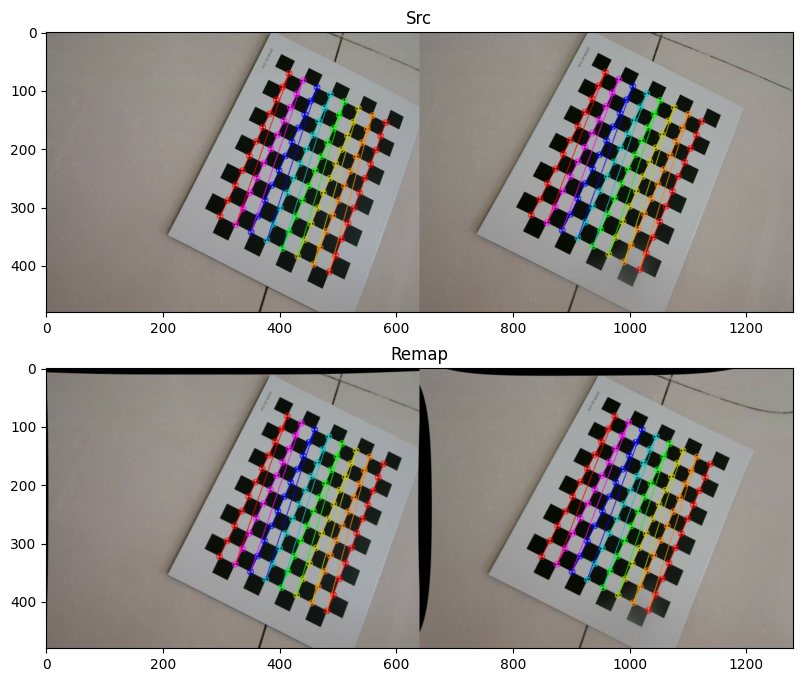

In [11]:
# 角点检测图
plt.figure(figsize=(10,8))
plt.subplot(2, 1, 1)
plt.imshow(cv2.cvtColor(_src_draw_concat, cv2.COLOR_BGR2RGB))
plt.title("Src")  

plt.subplot(2, 1, 2)
plt.imshow(cv2.cvtColor(_remap_draw_concat, cv2.COLOR_BGR2RGB))
plt.title("Remap")

原图在y坐标上的总误差(绝对值之和):  35.190536
Remap校正图在y坐标上的总误差(绝对值之和):  1.1551819


Text(0.5, 1.0, 'Remap')

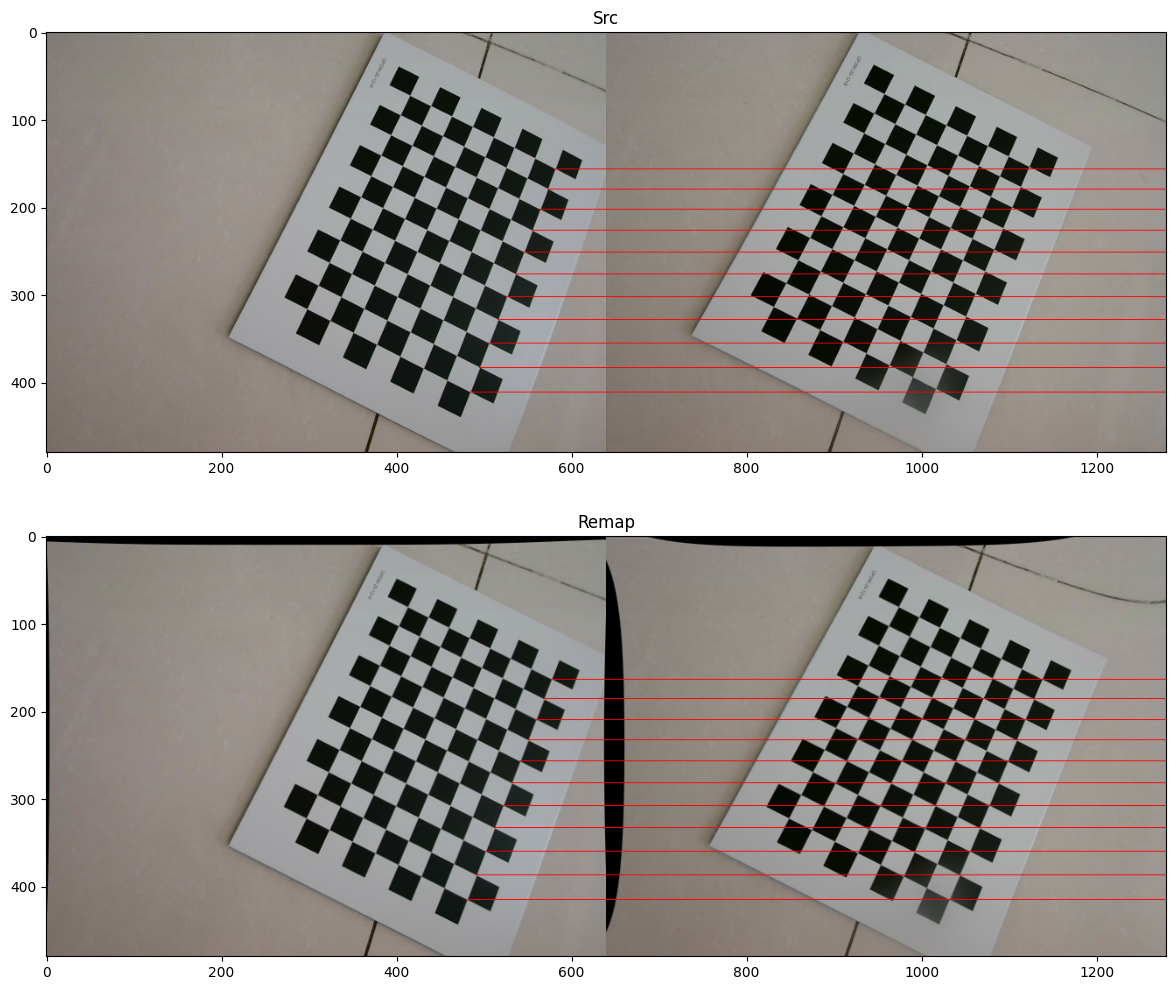

In [12]:
# 绘制水平线，挑选长边竖直的图像绘制
## 原图
_draw_src = img_src.copy()
_width = _draw_src.shape[1]
_points_src_left = left_src_corners[:chessSize[0],:,:] # shape: (col 1 2)
_points_src_right = right_src_corners[:chessSize[0],:,:] # shape: (col 1 2)

_src_error = 0.0
for _point_left, _point_right in zip(_points_src_left, _points_src_right):
    _pt1 = (int(_point_left[0][0]), int(_point_left[0][1]))
    _pt2 = (_width-1, int(_point_left[0][1]))
    _src_error += abs(_point_left[0][1] - _point_right[0][1])
    cv2.line(_draw_src, _pt1, _pt2, (0,0,255), thickness=1)
print("原图在y坐标上的总误差(绝对值之和): ", _src_error)

## remap后
_draw_remap = img_remap.copy()
_width = img_remap.shape[1]
_points_remap_left = left_remap_corners[:chessSize[0],:,:] # shape: (col 1 2)
_points_remap_right = right_remap_corners[:chessSize[0],:,:] # shape: (col 1 2)
_remap_error = 0.0
for _point_left, _point_right in zip(_points_remap_left, _points_remap_right):
    _pt1 = (int(_point_left[0][0]), int(_point_left[0][1]))
    _pt2 = (_width-1, int(_point_left[0][1]))
    _remap_error += abs(_point_left[0][1] - _point_right[0][1])
    cv2.line(_draw_remap, _pt1, _pt2, (0,0,255), thickness=1)
print("Remap校正图在y坐标上的总误差(绝对值之和): ", _remap_error)
# 立体校正检测图
plt.figure(figsize=(16,12))
plt.subplot(2, 1, 1)
plt.imshow(cv2.cvtColor(_draw_src, cv2.COLOR_BGR2RGB))
plt.title("Src")  

plt.subplot(2, 1, 2)
plt.imshow(cv2.cvtColor(_draw_remap, cv2.COLOR_BGR2RGB))
plt.title("Remap")

In [13]:
# 从像素坐标到实际坐标的检验
# 7 个格子
_cell_nums = 7
pt1_left = left_remap_corners[0][0]
pt1_right = right_remap_corners[0][0]
_world_pt1 = img_to_world_by_dis(pt1_left, pt1_left[0]-pt1_right[0], mycc._stereoCommParameters["Q"])
print("真实坐标点1:", _world_pt1)

pt2_left = left_remap_corners[_cell_nums][0]
pt2_right = right_remap_corners[_cell_nums][0]
_world_pt2 = img_to_world_by_dis(pt2_left, pt2_left[0]-pt2_right[0], mycc._stereoCommParameters["Q"])
print("真实坐标点2:", _world_pt2)

print(f"{_cell_nums}个格子的实际距离: {_cell_nums*chessCellLen} mm")
print(f"使用矩阵Q计算得到的距离: {np.linalg.norm(_world_pt2-_world_pt1)} mm")

真实坐标点1: [[215.70693167 -59.23427924 257.0454658    1.        ]]
真实坐标点2: [[153.82046722  64.57539373 237.86738232   1.        ]]
7个格子的实际距离: 140 mm
使用矩阵Q计算得到的距离: 139.73749851095414 mm


[[577.7454834  164.10339355  79.35733032   1.        ]]
[[512.59533691 333.96237183  85.75552368   1.        ]]


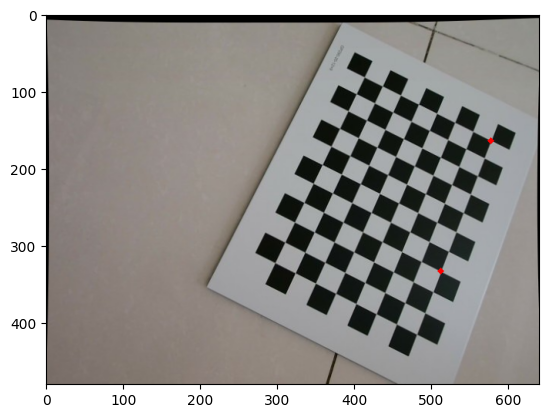

In [14]:
# 实际坐标到像素坐标
_pt1 = world_to_img_l(_world_pt1[0], mycc._stereoCommParameters["Q"])
print(_pt1)

_pt2 = world_to_img_l(_world_pt2[0], mycc._stereoCommParameters["Q"])
print(_pt2)

_draw_cicle = left_remap.copy()
cv2.circle(_draw_cicle, (int(_pt1[0][0]), int(_pt1[0][1])), 2, (0,0,255), 3)
cv2.circle(_draw_cicle, (int(_pt2[0][0]), int(_pt2[0][1])), 2, (0,0,255), 3)

plt.imshow(cv2.cvtColor(_draw_cicle, cv2.COLOR_BGR2RGB))

In [18]:
print(np.linalg.inv(mycc._stereoCommParameters["Q"]))

[[1.00000000e+00 0.00000000e+00 8.68012105e-01 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 7.15354796e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 6.02757127e+01]
 [0.00000000e+00 0.00000000e+00 2.95491748e-03 0.00000000e+00]]


In [19]:
print(mycc._stereoCommParameters["Q"])

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -2.93751724e+02]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -2.42089602e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.38418926e+02]
 [ 0.00000000e+00  0.00000000e+00  1.65904301e-02 -0.00000000e+00]]


In [15]:
# SGBM算法初始化
stereoSGBM = cv2.StereoSGBM_create(
    minDisparity=0, 
    numDisparities=16 * 5, 
    blockSize=3, P1=8 * 3 * 3, 
    P2=32 * 3 * 3,
    disp12MaxDiff=12, 
    uniquenessRatio=10, 
    speckleWindowSize=50, 
    speckleRange=32, 
    preFilterCap=63)

In [16]:
grayl = cv2.cvtColor(left_remap, cv2.COLOR_BGR2GRAY)
grayr = cv2.cvtColor(right_remap, cv2.COLOR_BGR2GRAY)
disparity = stereoSGBM.compute(grayl, grayr)

In [20]:
_dis1 = disparity[int(pt1_left[1])][int(pt1_left[0])] /16.0 
_dis1_real = pt1_left[0] - pt1_right[0]
print(f"pt1的stereoSGBM求解视差:{_dis1}, 真实视差:{_dis1_real}")

_dis2 = disparity[int(pt2_left[1])][int(pt2_left[0])] /16.0 
_dis2_real = pt2_left[0] - pt2_right[0]
print(f"pt2的stereoSGBM求解视差:{_dis2}, 真实视差:{_dis2_real}")

pt1的stereoSGBM求解视差:79.0, 真实视差:79.35733032226562
pt2的stereoSGBM求解视差:14.5, 真实视差:85.75552368164062


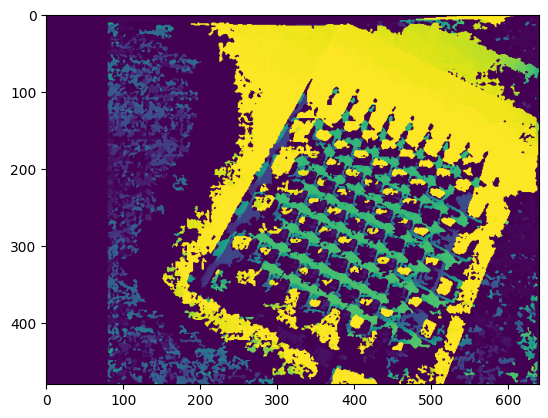

In [21]:
plt.imshow(disparity)

In [26]:
_3dimg = cv2.reprojectImageTo3D(disparity, mycc._stereoCommParameters["Q"]) * 16

In [27]:
print(_3dimg.shape)

(480, 640, 3)


In [ ]:
print(_3dimg[int(pt1_left[1])][int(pt1_left[0])])
_world_pt1 = img_to_world_by_dis(pt1_left, pt1_left[0]-pt1_right[0], mycc._stereoCommParameters["Q"])
print("真实坐标点1:", _world_pt1)

[216.11383  -59.581093 258.20813 ]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-212.44139..1296.901].


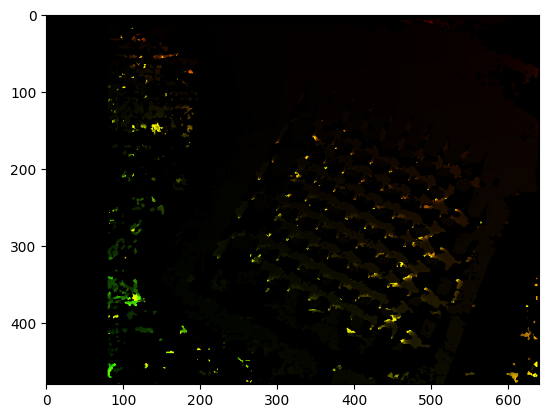

In [28]:
plt.imshow(_3dimg)

In [26]:
print(disparity.shape)

(480, 640)


In [ ]:
# WLS滤波器配置
wls_filter = cv2.ximgproc.createDisparityWLSFilter(sgbm)
wls_filter.setLambda(80000)
wls_filter.setSigmaColor(1.3)
right_matcher = cv2.ximgproc.createRightMatcher(sgbm)